# Linear Dynamical System

In [11]:
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import LDS

from extravaganza.lifters import NoLift, RandomLift, LearnedLift
from extravaganza.sysid import SysID
from extravaganza.controllers import LQR, BPC, GPC, RBPC, LiftedBPC
from extravaganza.rescalers import ADAM, D_ADAM, DoWG
from experiments import run_experiment, ylim

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = 8
CONTROLLER_SEED = None
LIFTER_AND_SYSID_SEED = None

## System
Here, we work with a Linear Dynamical System (LDS) with various types of perturbations.

The states $\{x_t\}_{t}$ evolve with
$$x_{t+1} = A x_{t} + B u_t + w_t,$$
where $A$ and $B$ are randomly generated dynamics, $u_t$ is the input control, and $w_t$ is the output of one of the below disturbance schedules.

The costs are denoted by $f(x_t, u_t)$ and given by the below cost functions.

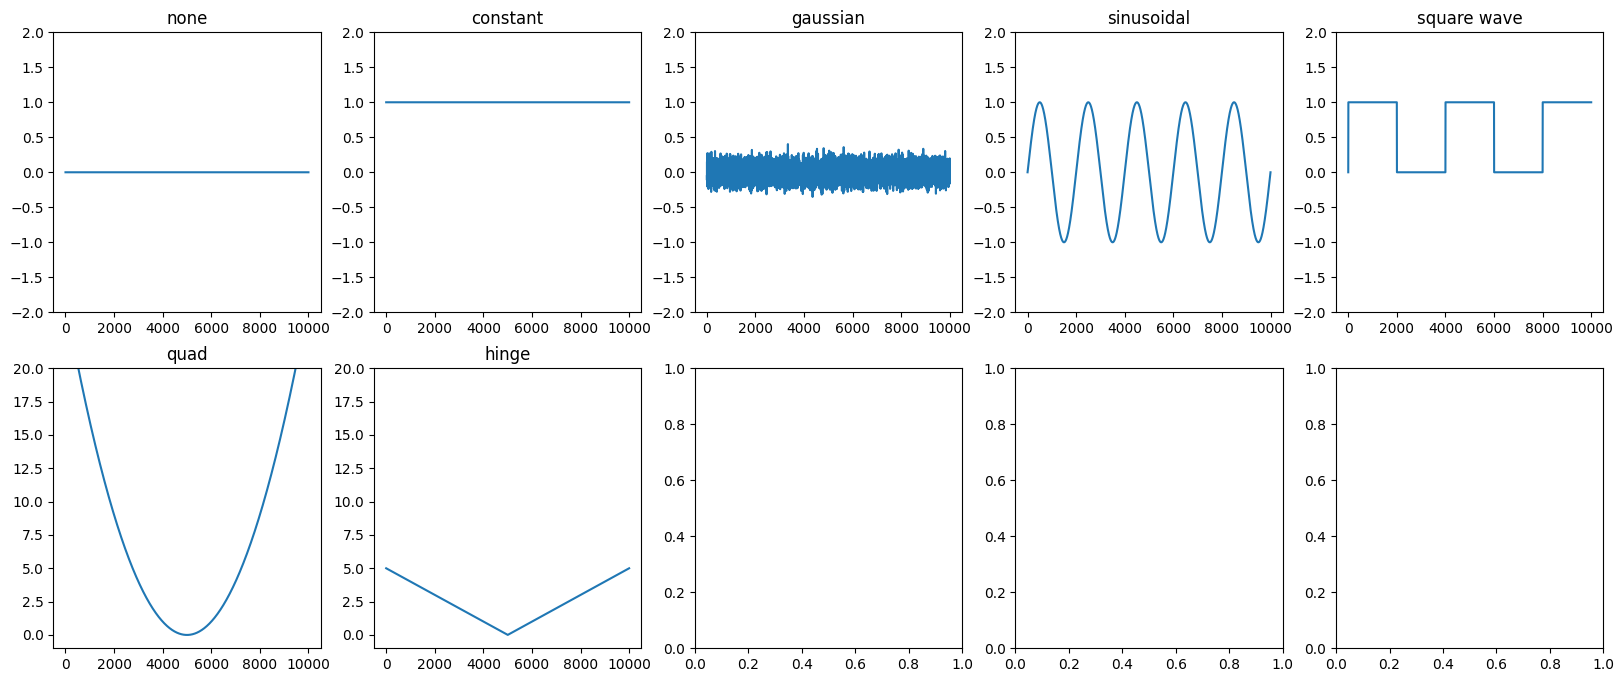

In [23]:
disturbance_fns = {'none': lambda t: 0.,
                   'constant': lambda t: 1.,
                   'gaussian': lambda t: np.random.randn() * 0.1,  # variance of 0.01
#                    'linear': lambda t: float(t),  # this one is stupid
                   'sinusoidal': lambda t: np.sin(2 * np.pi * t / 100),  # period of 100 steps
                   'square wave': lambda t: np.ceil(t / 100) % 2  # period of 40
                  }

cost_fns = {'quad': lambda x, u: jnp.dot(x, x) + jnp.dot(u, u),
            'hinge': lambda x, u: jnp.sum(jnp.abs(x)) + jnp.sum(jnp.abs(u))}

num_points = 10000
fig, ax = plt.subplots(2, len(disturbance_fns), figsize=(4 * len(disturbance_fns), 8))
for i, (k, fn) in enumerate(disturbance_fns.items()):
    ax[0, i].plot(range(num_points), [fn(t) for t in np.linspace(0, 500, num_points)])
    ax[0, i].set_ylim(-2, 2)
    ax[0, i].set_title(k)
for i, (k, fn) in enumerate(cost_fns.items()):
    ax[1, i].plot(range(num_points), [fn(t, 0) for t in np.linspace(-5, 5, num_points)])
    ax[1, i].set_ylim(-1, 20)
    ax[1, i].set_title(k)    
plt.show()

## Hyperparameters

In [14]:
# --------------------------------------------------------------------------------------
# ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

num_trials = 1
T = 1000  # total timesteps
T0 = 400  # number of timesteps to just sysid for our methods
reset_every = None  # how often to reset the system
wordy = True  # whether to print some things

# --------------------------------------------------------------------------------------
# --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
# --------------------------------------------------------------------------------------

du = 1  # control dim
ds = 1  # state dim

disturbance_type = 'square wave'
cost_fn = 'quad'

make_system = lambda : LDS(ds, du, disturbance_type, cost_fn, seed=SYSTEM_SEED)

# --------------------------------------------------------------------------------------
# ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

h = 5  # controller memory length (# of w's to use on inference)
hh = 10  # history length of the cost/control histories
lift_dim = 10  # dimension to lift to

m_update_rescaler = lambda : ADAM(0.004, betas=(0.9, 0.999))
m0_update_rescaler = lambda : ADAM(0.004, betas=(0.9, 0.999))
k_update_rescaler = lambda : ADAM(0.004, betas=(0.9, 0.999))

lifted_bpc_args = {
    'h': h,
    'method': 'FKM',
    'initial_scales': (0.01, 0.01, 0.01),  # M, M0, K   (uses M0's scale for REINFORCE)
    'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
    'T0': T0,
    'bounds': None,
    'initial_u': jnp.zeros(du),
    'decay_scales': True,
    'use_sigmoid': False,
    'use_K_from_sysid': False,
    'seed': CONTROLLER_SEED
}

make_controllers = {
    'LQR': lambda sys: LQR(sys.A, sys.B, jnp.eye(ds), sys.R, seed=CONTROLLER_SEED),
    'GPC': lambda sys: GPC(sys.A, sys.B, Q=jnp.eye(ds), R=sys.R, H=h, lr_scale=0.01, decay=False, seed=CONTROLLER_SEED),
    'BPC': lambda sys: BPC(sys.A, sys.B, Q=jnp.eye(ds), R=sys.R, H=h, lr_scale=0.005, delta=0.01, seed=CONTROLLER_SEED),
    'RBPC': lambda sys: RBPC(sys.A, sys.B, Q=jnp.eye(ds), R=sys.R, H=h, M=h, lr=0.01, delta=0.01, noise_sd=0.05, seed=CONTROLLER_SEED),
    
    'No Lift': lambda sys: LiftedBPC(lifter=NoLift(hh, du, LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, hh, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
    'Random Lift': lambda sys: LiftedBPC(lifter=RandomLift(hh, du, lift_dim, learned_lift_args['depth'], LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, lift_dim, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
    'Learned Lift': lambda sys: LiftedBPC(lifter=LearnedLift(hh, du, lift_dim, scale=sysid_scale, **learned_lift_args), **lifted_bpc_args)
}

# --------------------------------------------------------------------------------------
# ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

sysid_method = 'regression'
sysid_scale = 0.1

learned_lift_args = {
    'lift_lr': 0.001,
    'sysid_lr': 0.001,
    'cost_lr': 0.001,
    'depth': 4,
    'buffer_maxlen': int(1e6),
    'num_epochs': 150,
    'batch_size': 64,
    'seed': LIFTER_AND_SYSID_SEED
}

## Plotting
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [1]:
def plot_lds(all_stats):
    # clear plot and calc nrows
    plt.clf()
    n = 4
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 4 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            print('{} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'xs', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[1, 0], 'us', label=method)
        stats.plot(ax[1, 1], 'fs', label=method)
    
        stats.plot(ax[2, 0], '||A||_op', label=method)
        stats.plot(ax[2, 1], '||B||_F', label=method)
        stats.plot(ax[3, 0], '||A-BK||_op', label=method)
        stats.plot(ax[3, 1], 'lifter losses', label=method)
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method)
        stats.plot(i_ax, 'K @ state', label='K @ state')
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
        stats.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('position'); _ax.legend(); ylim(_ax, -5, 20)
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend(); ylim(_ax, -5, 5)
    _ax = ax[1, 0]; _ax.set_title('controls'); _ax.legend(); ylim(_ax, -3, 3)
    _ax = ax[1, 1]; _ax.set_title('costs'); _ax.legend(); ylim(_ax, -5, 100)
    
    _ax = ax[2, 0]; _ax.set_title('||A||_op'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('||B||_F'); _ax.legend()
    
    _ax = ax[3, 0]; _ax.set_title('||A-BK||_op'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('lifter losses'); _ax.legend()
    pass

## actually run the thing :)

--------------------------------------------------
----------------- TRIAL 0 -----------------------
--------------------------------------------------

testing LQR
registering running average of fs


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9044.77it/s]

testing GPC
registering running average of fs


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 635.27it/s]



testing BPC
registering running average of fs


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 438.59it/s]



testing RBPC
registering running average of fs


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.16it/s]



testing No Lift
registering running average of fs


 40%|████████████████████████████████████████▍                                                             | 396/1000 [00:00<00:00, 833.59it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 821/1000 [00:02<00:00, 281.86it/s]



testing Random Lift
registering running average of fs


 41%|██████████████████████████████████████████▏                                                           | 413/1000 [00:00<00:01, 506.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 266.15it/s]



testing Learned Lift
registering running average of fs


 32%|█████████████████████████████████                                                                     | 324/1000 [00:00<00:00, 807.93it/s]

training!
mean loss for past 25 epochs was 0.06471893191337585
mean loss for past 25 epochs was 0.010667648427188396
mean loss for past 25 epochs was 0.005739988144487142
mean loss for past 25 epochs was 0.002908546309918165
mean loss for past 25 epochs was 0.0013591560255736112
mean loss for past 25 epochs was 0.0005979666206985712


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.34it/s]



--------------------------------------------------
----------------- TRIAL 1 -----------------------
--------------------------------------------------

testing LQR
registering running average of fs


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10968.88it/s]



testing GPC
registering running average of fs


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 647.10it/s]



testing BPC
registering running average of fs


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 471.48it/s]



testing RBPC
registering running average of fs


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.40it/s]



testing No Lift
registering running average of fs


 44%|████████████████████████████████████████████▉                                                         | 440/1000 [00:00<00:00, 567.54it/s]

 48%|████████████████████████████████████████████████▊                                                     | 479/1000 [00:00<00:00, 567.55it/s]



testing Random Lift
registering running average of fs


 41%|█████████████████████████████████████████▌                                                            | 407/1000 [00:00<00:01, 513.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.07it/s]



testing Learned Lift
registering running average of fs


 33%|█████████████████████████████████▊                                                                    | 332/1000 [00:00<00:00, 815.53it/s]

training!
mean loss for past 25 epochs was 0.09701208646098773
mean loss for past 25 epochs was 0.012676832899451256
mean loss for past 25 epochs was 0.006991743370890618
mean loss for past 25 epochs was 0.0037858429737389087
mean loss for past 25 epochs was 0.0019308409141376615
mean loss for past 25 epochs was 0.0009562709997408092


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.85it/s]



--------------------------------------------------
----------------- TRIAL 2 -----------------------
--------------------------------------------------

testing LQR
registering running average of fs


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11286.69it/s]



testing GPC
registering running average of fs


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 571.20it/s]



testing BPC
registering running average of fs


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 461.99it/s]



testing RBPC
registering running average of fs


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 163.50it/s]



testing No Lift
registering running average of fs


 42%|██████████████████████████████████████████▋                                                           | 419/1000 [00:00<00:00, 661.98it/s]

 61%|██████████████████████████████████████████████████████████████▋                                       | 614/1000 [00:01<00:00, 429.14it/s]



testing Random Lift
registering running average of fs


 42%|███████████████████████████████████████████                                                           | 422/1000 [00:00<00:01, 472.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.10it/s]



testing Learned Lift
registering running average of fs


 34%|██████████████████████████████████▍                                                                   | 338/1000 [00:00<00:00, 844.70it/s]

training!
mean loss for past 25 epochs was 0.12520337228973707
mean loss for past 25 epochs was 0.012780895791947841
mean loss for past 25 epochs was 0.0069261380843818185
mean loss for past 25 epochs was 0.003941488713026047
mean loss for past 25 epochs was 0.002168772388249636
mean loss for past 25 epochs was 0.001147149964235723


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

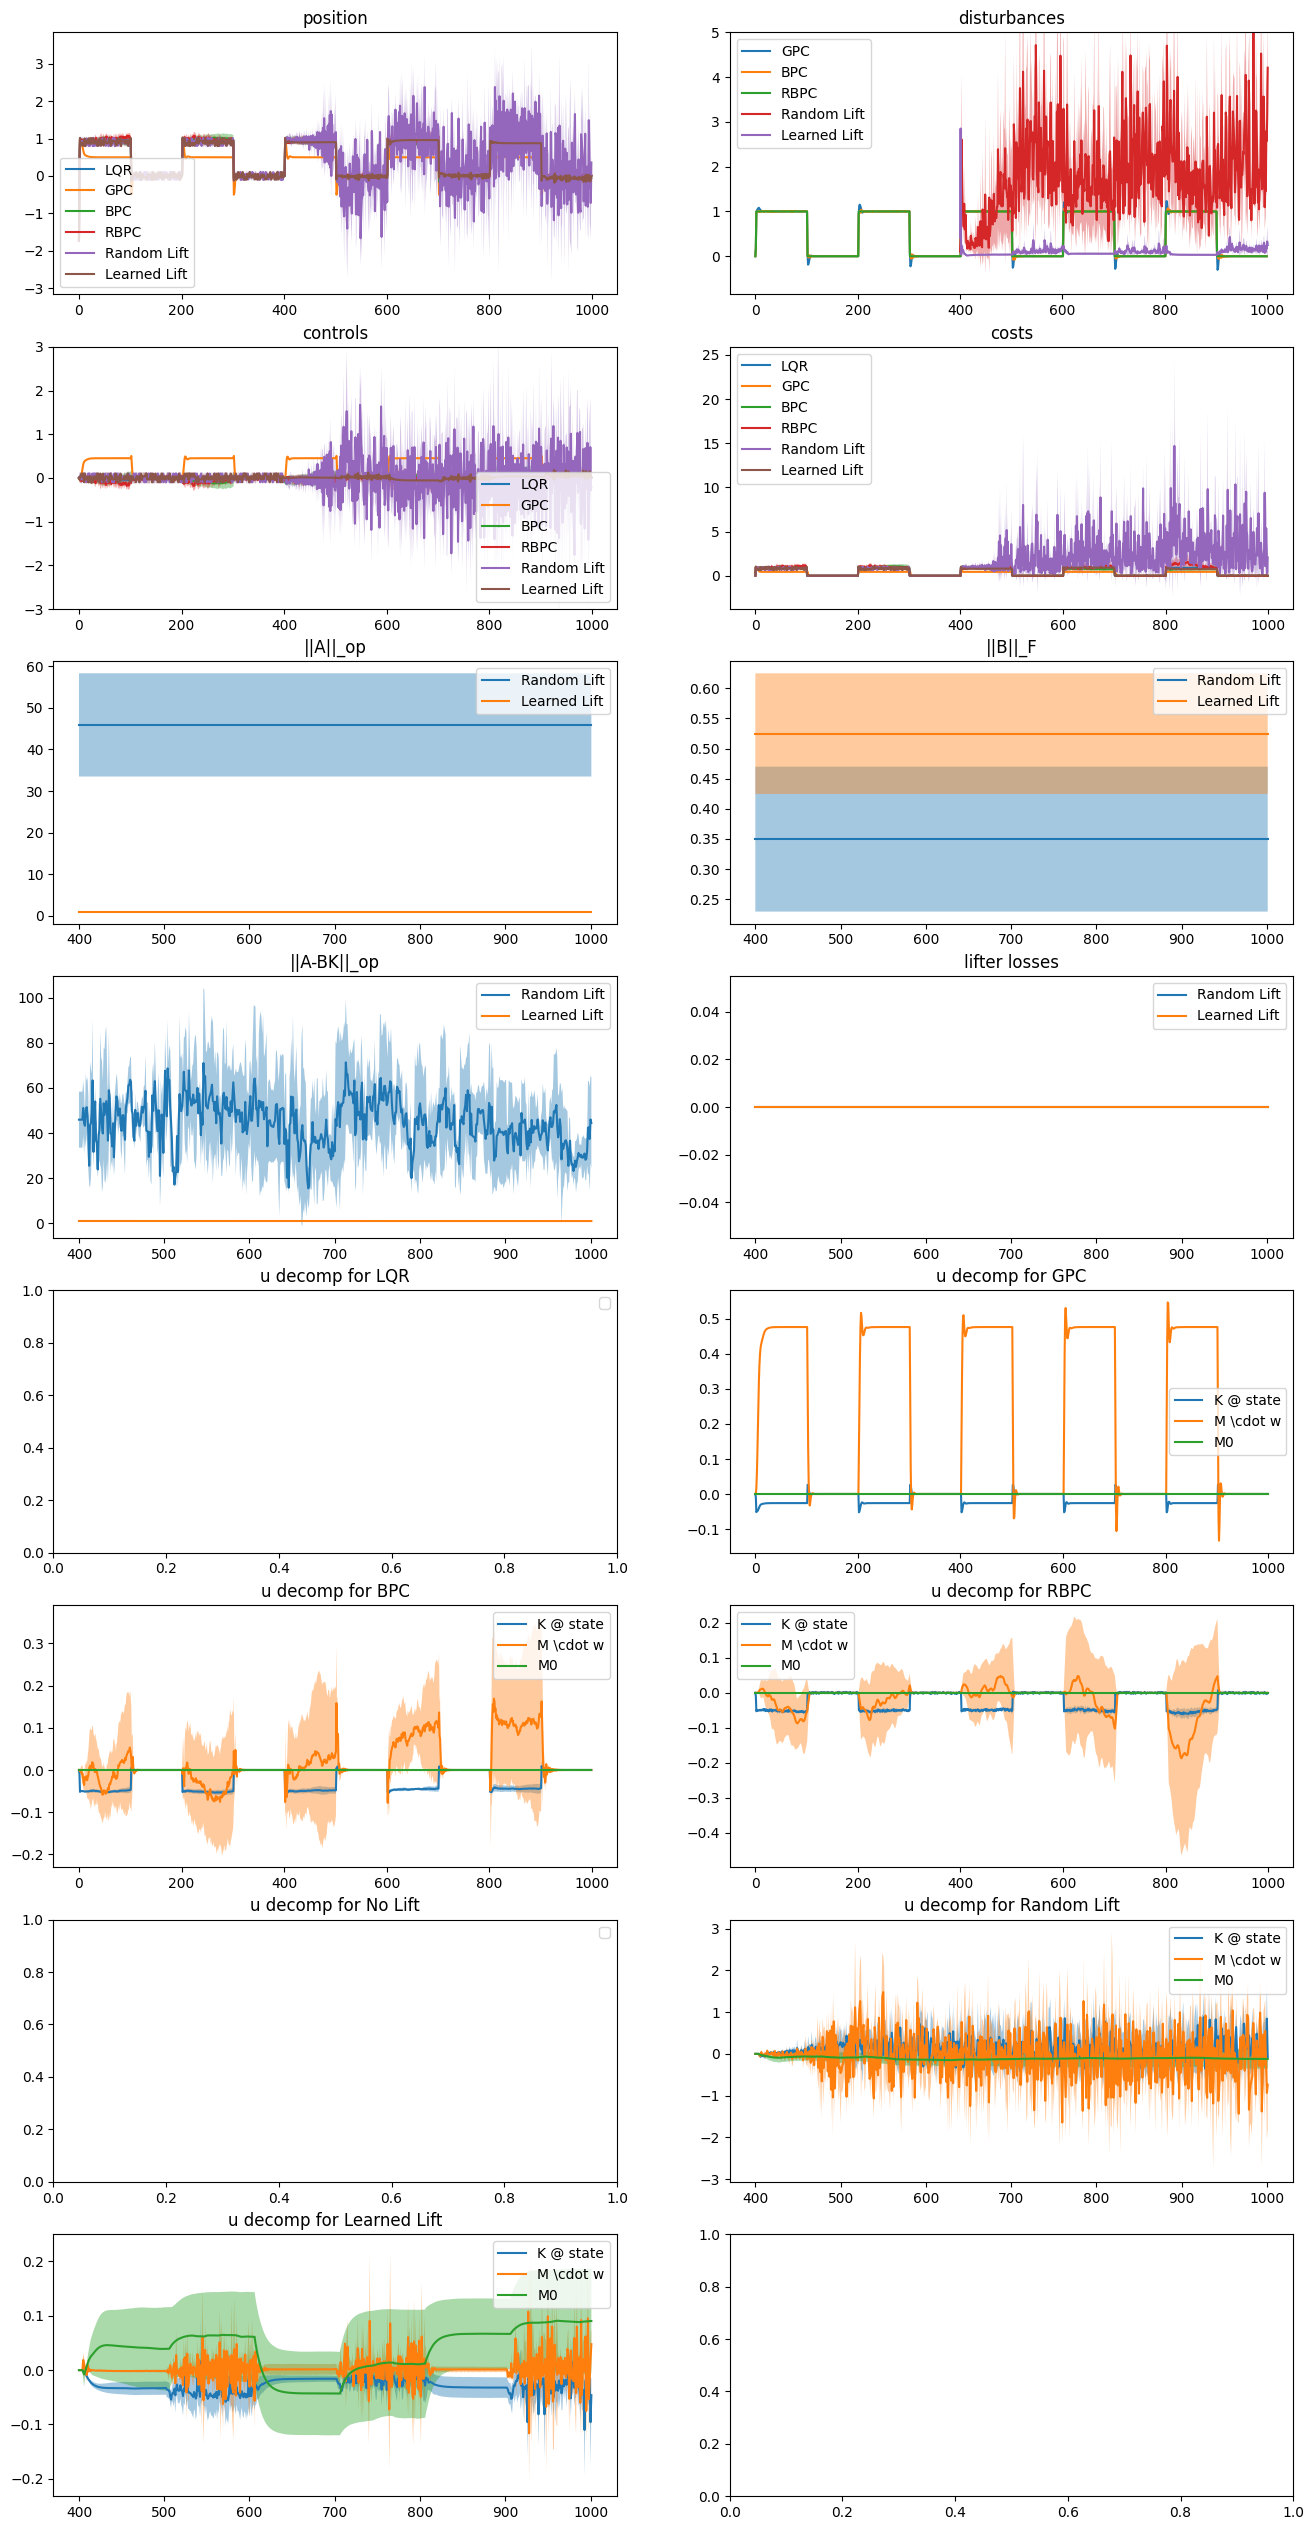

In [15]:
experiment_args = {
    'make_system': make_system,
    'make_controllers': make_controllers,
    'num_trials': num_trials,
    'T': T,
    'reset_every': reset_every,
    'reset_seed': SYSTEM_SEED,
    'wordy': wordy,
    
}
stats = run_experiment(**experiment_args)
plot_lds(stats)